# 1. Build A LDA Model of 2012 London Olympics

## 1.1 Packages Importing

In [1]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet  import WordNetLemmatizer
from nltk import FreqDist
import pandas as pd
import numpy as py
import string
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy

C:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1.2 Parameters Setting 

In [2]:
col = 2                             # Define which columns are used for topic modelling.
coherence_type = 'c_v'       # Define coherence type
min_len = 4                       # Define the short word length
no_below =  2                   #a threshold filtering out number of occurrence of the tokens among documents  no larger than 5
no_above = 0.9                 #the portion of a word in total corpus size
chunksize = 2000              #Number of documents to be used in each training chunk
eval_every = None             # Don't evaluate model perplexity, takes too much time.
num_topics =  20              #The number of requested latent topics to be extracted from the training corpus.
num_passes = 20              #Number of passes through the corpus during training
iterations = 100                #Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
alpha = 50.0/num_topics   #expresses our a-priori belief for each topics’ probability
#eta = 'auto'     
eta =      0.01                  #A-priori belief on word probability
random_state  = 54321     #Either a randomState object or a seed to generate one. Useful for reproducibility.
lemmatization = 1             #Whether implement corpus lemmatization 2:Lemmatizer (without POS tags) 1:Lemmatizer (with POS tags) 0:no

## 1.3 Corpus Reading 

In [3]:
df = pd.read_csv("Olympics-ALL-DOCS.csv", header = None, error_bad_lines=False)

In [4]:
docs = []
docs = df[col]

## 1.4 Data Processing

Document number: 169


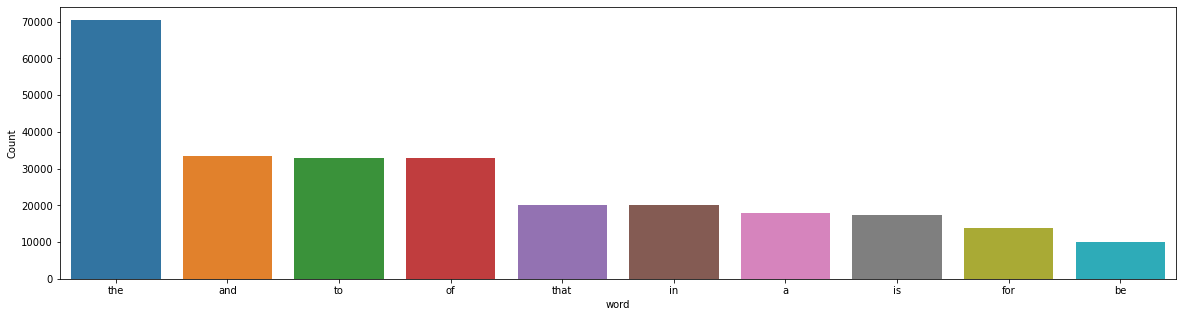

In [5]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join(['%s' %text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

print('Document number: %d'% (len(docs)))
freq_words(df[2],10) 

Tokens number: 19221


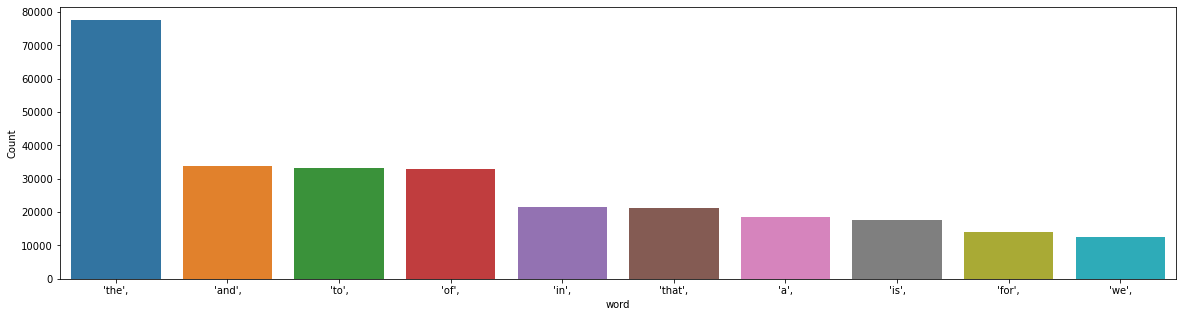

In [6]:
#Tokenize the corpus 
docs=docs.map(lambda x: x.lower())

tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(docs)):
    docs[i] = tokenizer.tokenize(docs[i])

print('Tokens number: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

Tokens number after removing number: 19221


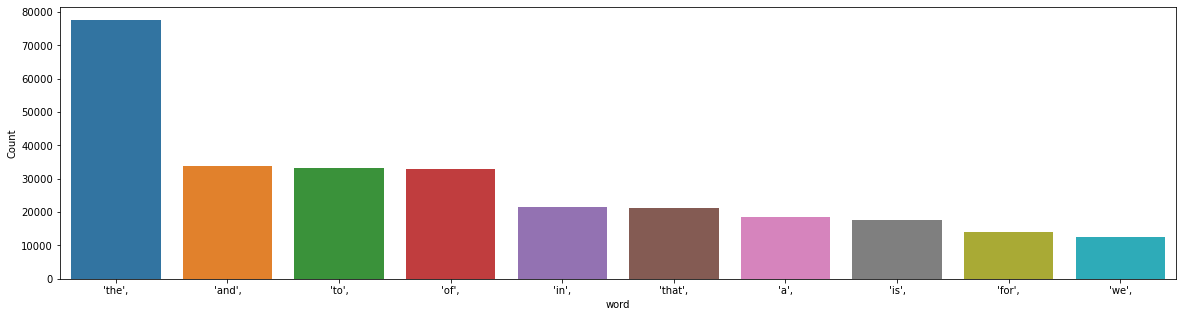

In [7]:
#Remove the number
docs = [ [token for token in doc if not token.isnumeric()] for doc in docs]

print('Tokens number after removing number: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Tokens number after removing stop words: 18379


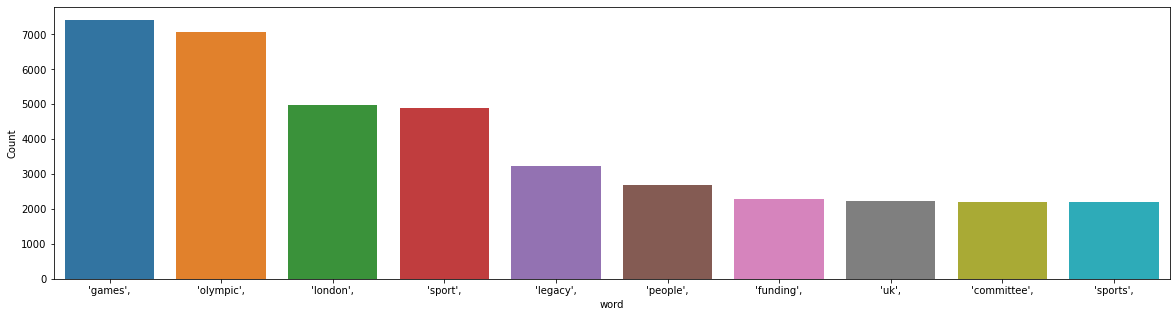

In [8]:
#remove stop words
stop_words = stopwords.words('english')
stop=[]
sw =  open("C:/Users/jason/Documents/Exeter University/business project/code/stopwords.txt","r")
for i in sw:
    stop.append(i)
sw.close()

stop = [myL.replace('  \n', '') for myL in stop]

stop = [myL.replace('\n', '') for myL in stop]

stop_words.extend(stop)
print(stop_words)

docs = [ [token for token in doc if not token in stop_words] for doc in docs ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

Tokens number after removing short words: 17742


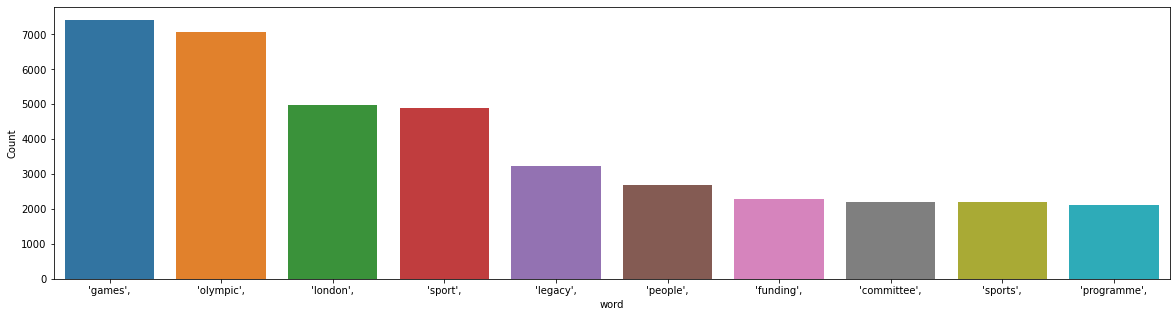

In [9]:
#Remove short words (length < min_len)
docs = [ [token for token in doc if not len(token) < min_len] for doc in docs ]
print('Tokens number after removing short words: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

Lemmatization with POS tags...
Tokens number after lemmatization: 15296


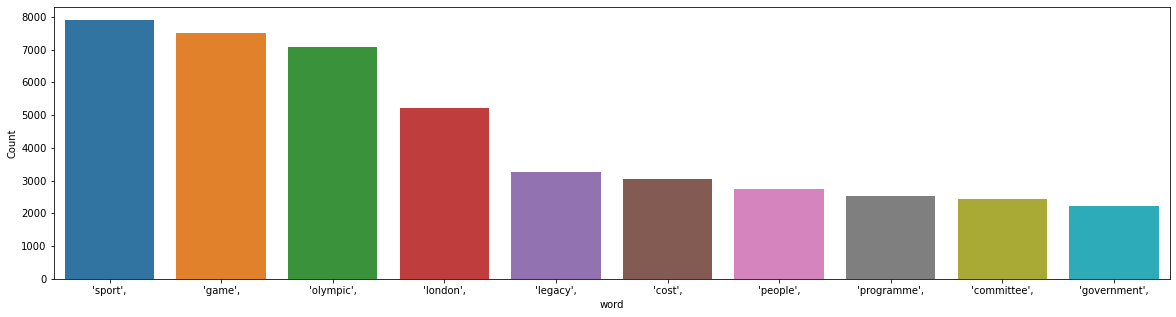

In [10]:
# Corpus Lemmatization
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemmatize_sentence(sentence):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(sentence):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return res



if lemmatization == 1:
    for i in range (len(docs)):
        docs[i] = lemmatize_sentence(docs[i])
    print('Lemmatization with POS tags...')

if lemmatization == 2:
    lemmatizer = WordNetLemmatizer()
    docs = [ [lemmatizer.lemmatize(token) for token in doc ] for doc in docs ]
    print('Lemmatization without POS tags...')

if lemmatization == 0:
    print('Cancel lemmatization...')

print('Tokens number after lemmatization: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

Tokens number after removing stop words: 15178


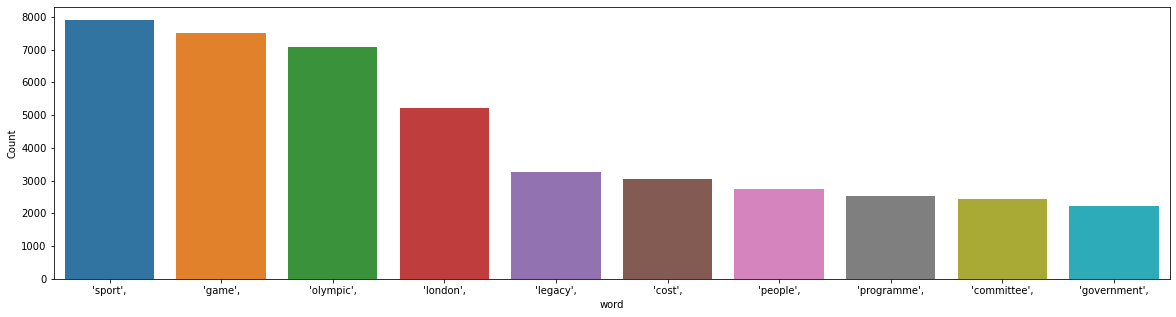

In [11]:
#remove stop words again
docs = [ [token for token in doc if not token in stop_words] for doc in docs ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

Tokens number after adding bigram: 15858


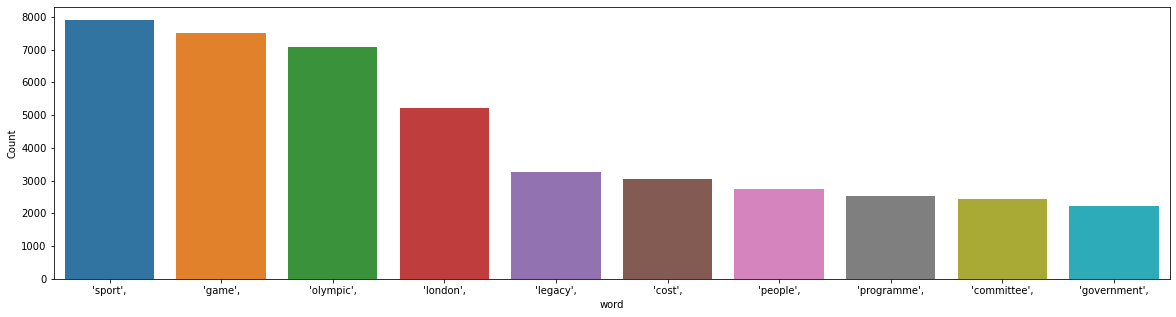

In [12]:
# Make bigram
bigrams_phases = Phrases(docs, min_count = 10)
for i in range(len(docs)):
    for token in bigrams_phases[docs[i]]:
        if '_' in token:
            docs[i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(docs))))
freq_words(docs,10) 

## 1.5 The LDA Model Building

In [13]:
# Build a dictionary
LOdict = Dictionary(docs)

print('Tokens number after creating dictionary: %d'% (len(LOdict)))

Tokens number after creating dictionary: 15858


In [14]:
#Remove  words occur less than no_below documents and more then no_above/documents
LOdict.filter_extremes(no_below = no_below, no_above = no_above)

print('Tokens number after tf-idf: %d'% (len(LOdict)))

Tokens number after tf-idf: 8472


In [15]:
# Create bag of word for corpus
LOcorpus = [LOdict.doc2bow(doc) for doc in docs]

In [16]:
#Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = LOdict 

In [18]:
# Buila a LDA model for LONDON OLYPLMICS
LOldamodel = LdaModel(
    corpus = LOcorpus,
    id2word = id2word,
    chunksize = chunksize,
    alpha = alpha,
    eta = eta,
    iterations = iterations,
    num_topics = num_topics,
    passes = num_passes,
    eval_every = eval_every,
    random_state = random_state
)
print('LDA model training complete with number of topics: ', num_topics)

LDA model training complete with number of topics:  20


In [19]:
LOldamodel.print_topics()

[(0,
  '0.046*"benefit" + 0.030*"event" + 0.027*"legacy" + 0.024*"skill" + 0.022*"committee" + 0.017*"tourism" + 0.017*"plan" + 0.017*"opportunity" + 0.017*"business" + 0.016*"international"'),
 (1,
  '0.059*"cultural" + 0.031*"olympiad" + 0.029*"cultural_olympiad" + 0.019*"legacy" + 0.018*"opportunity" + 0.018*"creative" + 0.017*"music" + 0.015*"technology" + 0.015*"council" + 0.013*"funding"'),
 (2,
  '0.027*"delivery" + 0.025*"cost" + 0.024*"authority" + 0.015*"olympic_delivery" + 0.013*"paralympic" + 0.012*"budget" + 0.012*"programme" + 0.010*"department" + 0.010*"government" + 0.009*"funding"'),
 (3,
  '0.022*"people" + 0.008*"time" + 0.007*"country" + 0.007*"committee" + 0.007*"process" + 0.006*"olympics" + 0.006*"question" + 0.006*"ticket" + 0.006*"legacy" + 0.005*"term"'),
 (4,
  '0.015*"lottery" + 0.013*"cost" + 0.009*"committee" + 0.007*"fund" + 0.007*"legacy" + 0.007*"government" + 0.006*"local" + 0.006*"national" + 0.006*"paragraph" + 0.006*"report"'),
 (5,
  '0.017*"cost" 

In [20]:
#Compute Coherence Score
coherence_model_lda = CoherenceModel(model = LOldamodel, texts = docs, dictionary = LOdict, coherence=coherence_type)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score ', coherence_type,'=', coherence_lda, ' with number of topics =', num_topics)

Coherence Score  c_v = 0.45536978227947894  with number of topics = 20


In [21]:
# Plot Cohernece Score
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    coherence_values = []
    model_list = []
    for num_topic in range(start, limit, step):
        model=LdaModel(
            corpus = corpus,
            id2word = id2word,
            chunksize = chunksize,
            alpha = alpha,
            eta = eta,
            iterations = iterations,
            num_topics = num_topic,
            passes = num_passes,
            eval_every = eval_every,
            random_state = random_state
            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_type)
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        print('Coherence Score ', coherence_type,'=', coherence_score, ' with number of topics =', num_topic)

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=LOdict, corpus=LOcorpus, texts=docs, start=1, limit=41, step=1)

Coherence Score  c_v = 0.3988045980693213  with number of topics = 1
Coherence Score  c_v = 0.44839300570520263  with number of topics = 2
Coherence Score  c_v = 0.42792978694315725  with number of topics = 3
Coherence Score  c_v = 0.4488295140846066  with number of topics = 4
Coherence Score  c_v = 0.4129852503113033  with number of topics = 5
Coherence Score  c_v = 0.4114858022522672  with number of topics = 6
Coherence Score  c_v = 0.419688945565563  with number of topics = 7
Coherence Score  c_v = 0.4125086895148209  with number of topics = 8
Coherence Score  c_v = 0.42706950962286144  with number of topics = 9
Coherence Score  c_v = 0.42913887071715884  with number of topics = 10
Coherence Score  c_v = 0.41367256524899626  with number of topics = 11
Coherence Score  c_v = 0.4079198812793265  with number of topics = 12
Coherence Score  c_v = 0.42439394839771327  with number of topics = 13
Coherence Score  c_v = 0.42789933767589783  with number of topics = 14
Coherence Score  c_v = 

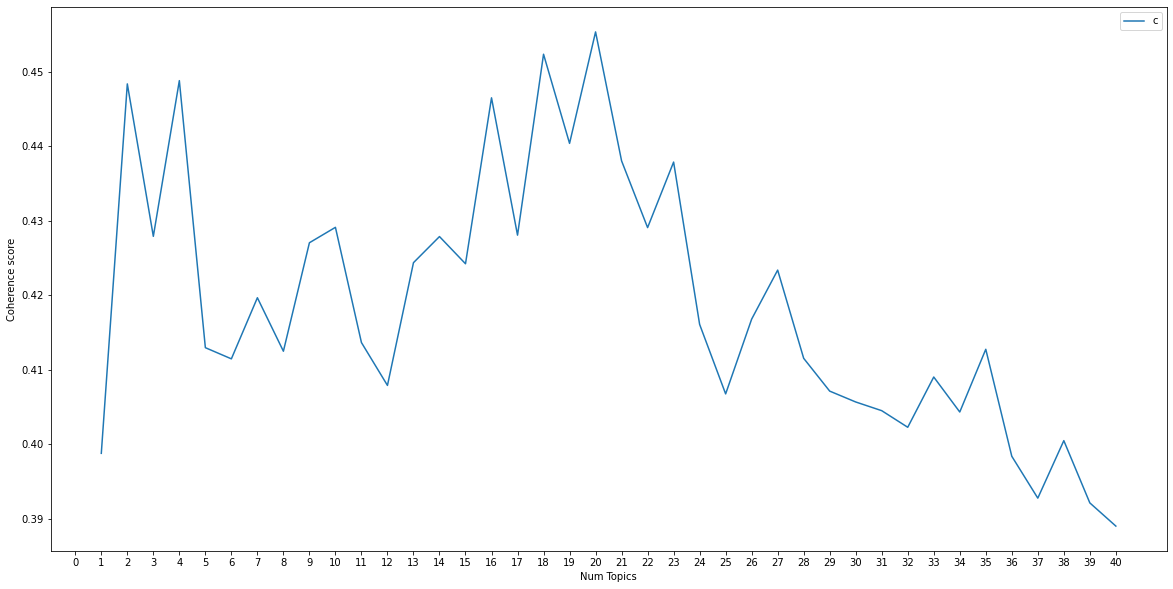

In [23]:
## Show plot
limit=41;start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.xticks(py.arange(0, 41, step=1))
plt.rcParams['figure.figsize'] = (20,10)
plt.show()

## 2. The LDA Model Visulization

### 2.1 Packages Importing

In [24]:
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

### 2.2 Visulization

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LOldamodel, LOcorpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.162245 -0.034904       1        1   0.725466
1     -0.062089  0.042318       2        1   1.076933
2      0.135652 -0.005903       3        1   8.966544
3      0.090901 -0.030016       4        1  12.748366
4      0.094924 -0.003299       5        1   5.576351
5      0.162000 -0.033080       6        1   9.714238
6     -0.112210 -0.005160       7        1   0.479107
7      0.160592 -0.023802       8        1   9.754666
8     -0.130785 -0.021584       9        1   0.494268
9     -0.213004 -0.116035      10        1   1.250828
10     0.048733  0.054581      11        1  24.060720
11    -0.075901 -0.109935      12        1   1.336851
12    -0.128270 -0.041609      13        1   0.722346
13    -0.100325  0.233579      14        1   2.158254
14     0.054151  0.027009      15        1   2.792914
15     0.062356 -0.116756      16        1   2.908029
16     0.244203 -0.125690      17        1   2.115362
17     0.122000  0.211538      18        1   5.576480
18    -0.028942  0.117763      19        1   7.007492
19    -0.161739 -0.019014      20        1   0.534783, topic_info=            Term         Freq        Total Category  logprob  loglift
326       legacy  3296.000000  3296.000000  Default  30.0000  30.0000
118    committee  2547.000000  2547.000000  Default  29.0000  29.0000
417       people  2711.000000  2711.000000  Default  28.0000  28.0000
429         plan  1991.000000  1991.000000  Default  27.0000  27.0000
585      support  1557.000000  1557.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
166  development    21.728588  1513.929558  Topic20  -4.5113   0.9872
458      provide    20.085211  1320.689147  Topic20  -4.5899   1.0451
330        level    17.871235  1017.313895  Topic20  -4.7067   1.1893
450      process    16.982384   879.109451  Topic20  -4.7577   1.2843
429         plan    17.845499  1991.417110  Topic20  -4.7082   0.5162

[1554 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3678      2  0.446276      abroad
3678      6  0.178510      abroad
3678      8  0.044628      abroad
3678     11  0.267766      abroad
1         4  0.461552  absolutely
...     ...       ...         ...
666      11  0.214744        zone
666      12  0.386539        zone
666      15  0.064423        zone
666      16  0.171795        zone
666      19  0.021474        zone

[6064 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

## 3 Corpus Classification

### 3.1 PARS Corpus Reading 

In [43]:
pf = pd.read_csv('Olympics-ALL-PARS.csv', header = None, error_bad_lines = False)

b'Skipping line 5: expected 3 fields, saw 9\nSkipping line 37: expected 3 fields, saw 5\nSkipping line 41: expected 3 fields, saw 5\nSkipping line 81: expected 3 fields, saw 5\nSkipping line 106: expected 3 fields, saw 5\nSkipping line 107: expected 3 fields, saw 7\nSkipping line 108: expected 3 fields, saw 5\nSkipping line 112: expected 3 fields, saw 5\nSkipping line 126: expected 3 fields, saw 5\nSkipping line 127: expected 3 fields, saw 5\nSkipping line 139: expected 3 fields, saw 5\nSkipping line 140: expected 3 fields, saw 5\nSkipping line 142: expected 3 fields, saw 5\nSkipping line 149: expected 3 fields, saw 5\nSkipping line 162: expected 3 fields, saw 5\nSkipping line 163: expected 3 fields, saw 5\nSkipping line 186: expected 3 fields, saw 5\nSkipping line 188: expected 3 fields, saw 5\nSkipping line 190: expected 3 fields, saw 5\nSkipping line 191: expected 3 fields, saw 5\nSkipping line 194: expected 3 fields, saw 5\nSkipping line 213: expected 3 fields, saw 5\nSkipping line

In [44]:
pars = []
pars = pf[col]

### 3.2 PARS Corpus Processing

Document number: 22764


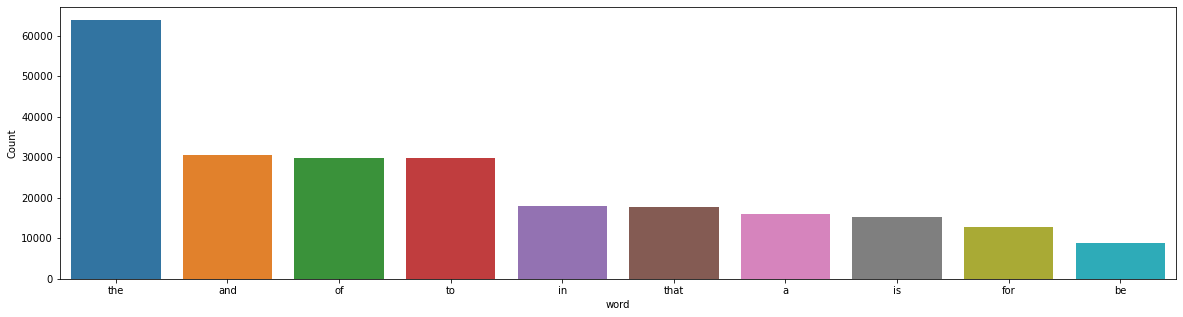

In [45]:
print('Document number: %d'% (len(pars)))
freq_words(pars,10) 

Tokens number: 18540


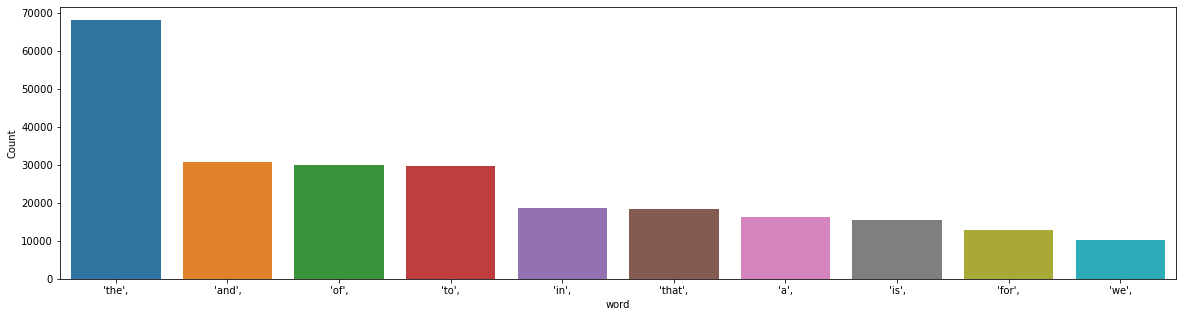

In [46]:
#Tokenize the corpus 
pars= pars.map(lambda x: x.lower())

tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(pars)):
    pars[i] = tokenizer.tokenize(pars[i])

print('Tokens number: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Tokens number after removing number: 18540


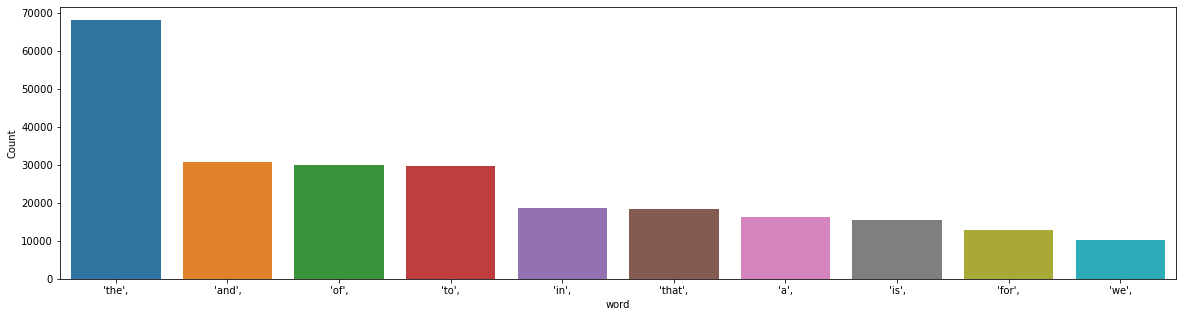

In [47]:
#Remove the number
pars = [ [token for token in doc if not token.isnumeric()] for doc in pars]

print('Tokens number after removing number: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Tokens number after removing stop words: 17701


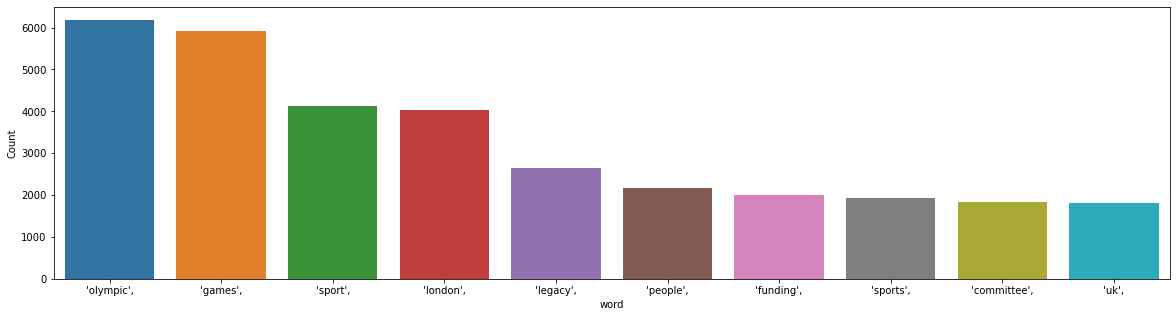

In [48]:
#Reomve stop words
pars = [ [token for token in doc if not token in stop_words] for doc in pars ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Tokens number after removing short words: 17084


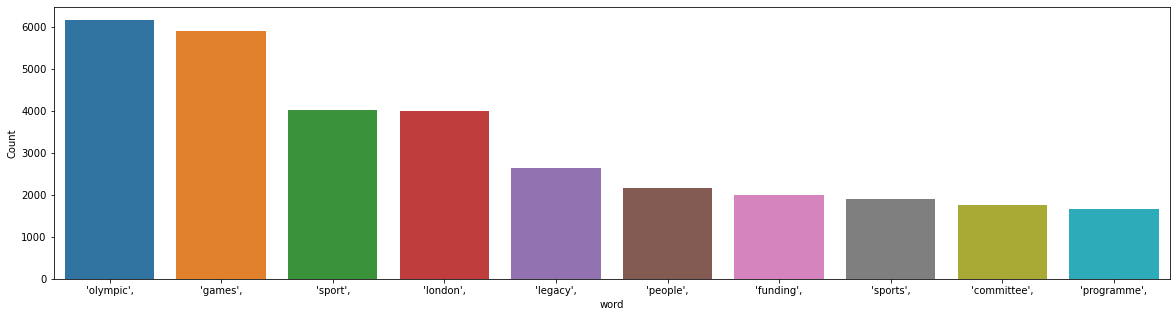

In [49]:
#Remove short words (length < min_len)
pars = [ [token for token in doc if not len(token) < min_len] for doc in pars ]
print('Tokens number after removing short words: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Lemmatization with POS tags...
Tokens number after lemmatization: 14658


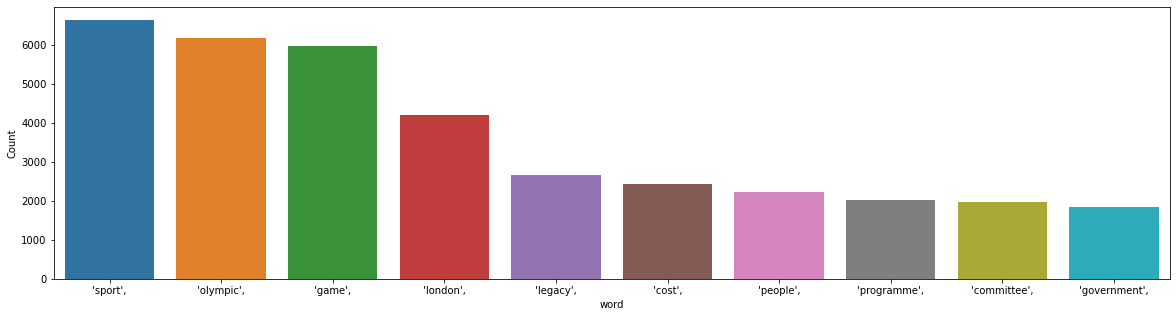

In [50]:
# Corpus Lemmatization
if lemmatization == 1:
    for i in range (len(pars)):
        pars[i] = lemmatize_sentence(pars[i])
    print('Lemmatization with POS tags...')

if lemmatization == 2:
    lemmatizer = WordNetLemmatizer()
    pars = [ [lemmatizer.lemmatize(token) for token in doc ] for doc in pars ]
    print('Lemmatization without POS tags...')

if lemmatization == 0:
    print('Cancel lemmatization...')

print('Tokens number after lemmatization: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Tokens number after removing stop words: 14543


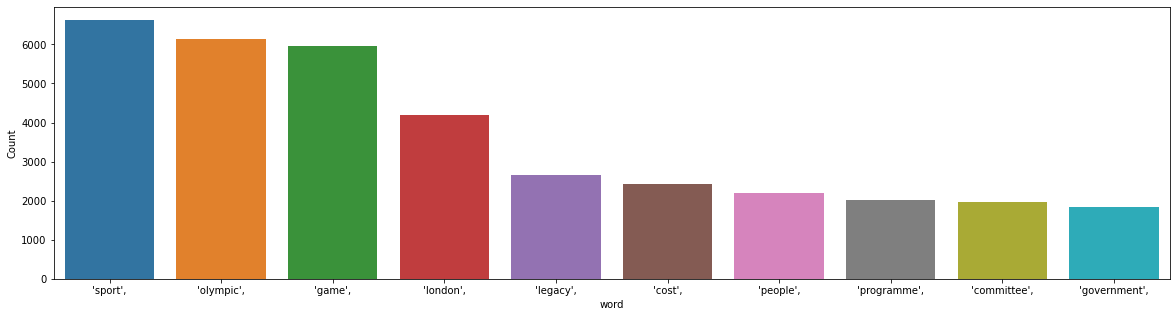

In [51]:
#remove stop words again
pars = [ [token for token in doc if not token in stop_words] for doc in pars ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

Tokens number after adding bigram: 15154


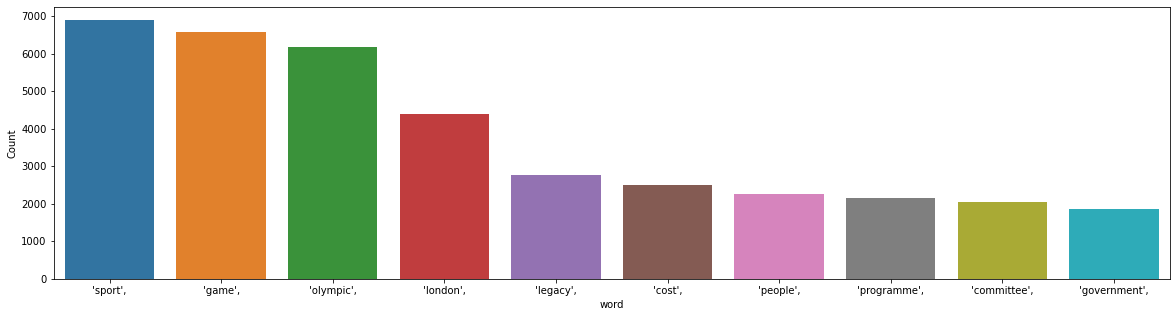

In [52]:
# Make bigram
P_bigrams_phases = Phrases(pars, min_count = 10)
for i in range(len(pars)):
    for token in P_bigrams_phases[pars[i]]:
        if '_' in token:
            pars[i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(pars))))
freq_words(pars,10) 

### 3.3 Classify PARAS

### 3.3.1 Parameter Setting

In [103]:
minimum_probability = 0.2 #Topics with an assigned probability lower than this threshold will be discarded.
rank = 10                          #Set rank of for for topic 
topic = 4                        #Topic filter of the Highest ranked paragraphs

### 3.3.2 PARS Classification

In [ ]:
classifer = list()
for p in pars:
    bow = LOdict.doc2bow(p)
    belong = LOldamodel.get_document_topics(bow,minimum_probability = 0,per_word_topics=False)
    classifer.append(belong)

classiferdf = pd.DataFrame(classifer)

classifer_par = pd.concat([pf.iloc[:,0:3],classiferdf],axis=1)

In [54]:
Pcorpus = [LOdict.doc2bow(doc) for doc in pars]
#Make the Dataframe of the highest probable topics of each paragraph
MTopics =  list()
for i in LOldamodel.get_document_topics(Pcorpus,minimum_probability = 0, per_word_topics=False)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    bz=listj.index(max(listj))
#    print(bz,listj[bz], i)
    MTopics.append([bz+1, listj[bz]])

MTopics = pd.DataFrame(MTopics)

classifer_document = pd.concat([pf.iloc[:,0:2],MTopics,pf.iloc[:,2:3]],axis=1)
classifer_document.columns = ["Par No.","Souce","The Highest Probable Topic", "Probability","Text"]

In [58]:
#adjust Dataframe's title to center
d = dict(selector="th",
    props=[('text-align', 'center')])

In [106]:
#1.	Highest N ranked paragraphs for topic K
classifer_document[classifer_document['The Highest Probable Topic']==topic].nlargest(rank, 'Probability')\
.style.set_properties(**{'text-align' : 'center'}).set_properties(subset = ['Text'], **{'text-align' : 'left'})\
.set_caption('The Highest N ranked paragraphs for topic K')\
.set_table_styles([d])

,Par No.,Souce,The Highest Probable Topic,Probability,Text
19387,19735,Olympics-All-PARS/NewChunk7/Oral_evidence_Dec_2010.pdf.txt,4,0.327348,Q Dr Coffey I do We have already touched on the budget and got the numbers sorted Are you condent that the security planning is on track Hugh Robertson Yes I am When I was the Opposition spokesman I was not condent of that I do not say that in a particularly party political way I remember chairing a security seminar at the Royal United Services Institute a couple of years ago and walking out of it thinking Heavens this just doesnt seem to be where it ought to be Since that period the Metropolitan police have caught up with their planning There is no doubt about it the advent of Pauline NevilleJones has been a thoroughly good thing for this process She reviewed it all when she took over and we are now absolutely condent sitting here that security planning is where it ought to be That said this touches on the answer I gave earlieronly a fool would pretend that the fact that we are condent now means that we can be condent that we will be safe in because it is a fastmoving feast Even in the seven months that the coalition Government have been in power we have seen a very considerable increase in the dissident Republican threat across the water Were beginning to understand much better how the alQaeda franchises workparticularly alQaeda on the Arabian Peninsulaand how those threats are likely to be delivered That threat will continue to evolve and move as we get closer to London I think that sometimes in this country we are in danger of underplaying the expertise we have in security I was conscious of it when I was serving in the Army and I am conscious of it now as a Minister dealing with the security forces Our special forces and our security forces in this country are very good as are the police when it comes to this sort of thing So I can only say that I am as condent as one could be at this stage that we are where we ought to be against the challenging backdrop
15613,15924,Olympics-All-PARS/NewChunk5b/Lessons_from_Beijing_-_Oral_evidence_-_Dec_2008.txt,4,0.290568,Tessa Jowell You will knowbecause I am sure you have been involved in itthat there is a lot of activity in the North West and all round the country I go back to my starting point which is that given economic dispersal of the benefits is not inevitable we have worked in a purposeful way to maximise the extent to which the rest of the country can benefit from the economic goal which is the billion investment in UK Plc The principal mechanism for doing that is through the CompeteFor network In the North West there are nearly businesses registered on the CompeteFor network so they are certainly plugged into that The second matter is that the RDAs are working on maximising the tourism premium of which the North West has experience from the Commonwealth Games The third is that already I believe the Thai team has decided to locate its training camp in the North West and no doubt others will follow but just as nothing is inevitable where regions take their own initiative a lot can be achieved by being proactive because not all of this benefit can be generated simply by the efforts of the Olympic Executive the ODA or LOCOG That is why MPs have such an important role to play Therefore the economic benefits relate to CompeteFor In response to your question about skills I think we can go further but there is no mandating in the ODA contracts for apprenticeships and to do so would obviously increase the cost of the contracts That is something we intend to look at but as of now I make it clear that this is not a requirement There is plenty of encouragement and the ODA has a memorandum of understanding with the trade unions but the benefits are beginning to be felt round the country principally through the CompeteFor network but also through the plans developed to maximise the billion premium that we expect to be realised Already in Wales Birmin

In [108]:
#2.	Highest N ranked paragraphs overall
classifer_document.nlargest(rank, 'Probability')\
.style.set_properties(**{'text-align' : 'center'}).set_properties(subset = ['Text'], **{'text-align' : 'left'})\
.set_caption('The Highest N ranked paragraphs overall')\
.set_table_styles([d])

,Par No.,Souce,The Highest Probable Topic,Probability,Text
9249,9523,Olympics-All-PARS/NewChunk4/NAO_Preparing_for_sporting_success_-_March_2008.pdf.txt,18,0.410606,The Committee of Public Accounts recommended in their report that on the basis that the resources were known UK Sport should decide its medal table targets for and reflect them in the targets it agreed with individual sports before reviewing those targets in the light of performance at Beijing in UK Sports response to this recommendation in October was that whilst an ultimate goal for both Olympic and Paralympic success had been identified no formal targets would be set until after a full review of performance in Beijing and the signing of a new funding agreement with the Department UK Sport has maintained this line and has still not set formal targets for individual sports or in aggregate for medal performance in the Games Although the funding package was agreed on the basis that the Great Britain teams would achieve the objectives of finishing fourth in the Olympic medal table and second moving towards first in the Paralympic medal table UK Sport continues to describe these as ultimate goals It proposes only to set formal medal targets once it has had the opportunity to review with each sport their realistic expectations in the light of performance at the Beijing Games
332,384,Olympics-All-PARS/NewChunk1/Jan_2003_-_Qs_200-220.txt,15,0.401618,This just will not do It really will not do Mr Cunnahs letter is a clear helpful letter totally credible as far as I can see I would not fault a word of it What I want to be clear about on behalf of the Committee is this when Sport England gave million to FAWNSL to build a dual use stadium on the Wembley site with the intention of its being the centrepiece stadiumbecause that was the basis upon which it was given and why the decision was made and why all the arguments about dual use and Picketts Lock and Mr Chris Smiths kitchen and all the rest of it came upto house the Olympic Games should we get them did Sport England at that time know that there would be a problem with the location of the village If it did not know it is culpable If it did know it is culpable But I would like to know one way or the other what the position wasMr Fytche The position was that Sport England invested in a project as I said before to create the opportunity for it to form the centrepiece of the bid should the Bid Committee consider that to be the best option You will find going back to those days in and the launch of the project which you mentioned the BOA themselves were talking about the potential for Wembley to be the centrepiece of the bid All parties involved in the debate at that time acknowledged Wembley could be the centrepiece of the bid It was later that the issues relating to athletics and Picketts Lock arose but at the time the decisions were taken around Wembley it was clear that all parties felt that Wembley could be the centrepiece and therefore no issues relating to the position of the village visavis Wembley were problematic to it going forward at that stage
9696,9970,Olympics-All-PARS/NewChunk4/NAO_Preparing_for_sporting_success_-_March_2008.pdf.txt,18,0.396397,won Olympic medals against a target of medals per cent and Paralympic medals against a target of medals per cent and n at the Athens Games the Great Britain team won Olympic medals against a target of medals per cent and Paralympic medals against a target of medals per cent UK Sports targets for and were set in order to measure performance at elite events such as world championships in the years between the Olympic and Paralympic Games Our analysis suggests that although per cent may be an appropriate level at which to set targets for the Games themselves it does not provide a meaningful measure of performance in the intervening years For Paralympic sports performance both at recent Paralympic Games and in the years between Games suggests that setting UK Sports targets at

In [109]:
#3.	Highest N ranked paragraphs from each topic K
classifer_document.groupby(by='The Highest Probable Topic').apply(lambda x:x.nlargest(rank, 'Probability'))\
.style.set_properties(**{'text-align' : 'center'}).set_properties(subset = ['Text'], **{'text-align' : 'left'})\
.set_caption('The Highest N ranked paragraphs from each topic K')\
.set_table_styles([d])

In [100]:
#4.	Highest N ranked paragraphs where the belong() function is greater than the threshold for M topics at a time
T_MTopics =  list()
for i in LOldamodel.get_document_topics(Pcorpus, minimum_probability = minimum_probability, per_word_topics=False)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    if listj:
        bz=listj.index(max(listj))
        topic= ','.join(str(a) for a in re.findall(r"(\d+),",str(max(i))) )
#        print(bz,listj[bz],topic)
        T_MTopics.append([int(topic)+1, listj[bz]])
    else:
        T_MTopics.append(['None',0])
        

T_MTopics = pd.DataFrame(T_MTopics)

classifer_document_threshold = pd.concat([pf.iloc[:,0:2],T_MTopics,pf.iloc[:,2:3]],axis=1)
classifer_document_threshold.columns = ["Par No.","Souce","The Highest Probable Topic", "Probability","Text"]

In [110]:
classifer_document_threshold[classifer_document_threshold['The Highest Probable Topic']==topic].nlargest(rank, 'Probability')\
.style.set_properties(**{'text-align' : 'center'}).set_properties(subset = ['Text'], **{'text-align' : 'left'})\
.set_caption('The Highest N ranked paragraphs from topic K with threshold')\
.set_table_styles([d])

,Par No.,Souce,The Highest Probable Topic,Probability,Text
19387,19735,Olympics-All-PARS/NewChunk7/Oral_evidence_Dec_2010.pdf.txt,4,0.327330,Q Dr Coffey I do We have already touched on the budget and got the numbers sorted Are you condent that the security planning is on track Hugh Robertson Yes I am When I was the Opposition spokesman I was not condent of that I do not say that in a particularly party political way I remember chairing a security seminar at the Royal United Services Institute a couple of years ago and walking out of it thinking Heavens this just doesnt seem to be where it ought to be Since that period the Metropolitan police have caught up with their planning There is no doubt about it the advent of Pauline NevilleJones has been a thoroughly good thing for this process She reviewed it all when she took over and we are now absolutely condent sitting here that security planning is where it ought to be That said this touches on the answer I gave earlieronly a fool would pretend that the fact that we are condent now means that we can be condent that we will be safe in because it is a fastmoving feast Even in the seven months that the coalition Government have been in power we have seen a very considerable increase in the dissident Republican threat across the water Were beginning to understand much better how the alQaeda franchises workparticularly alQaeda on the Arabian Peninsulaand how those threats are likely to be delivered That threat will continue to evolve and move as we get closer to London I think that sometimes in this country we are in danger of underplaying the expertise we have in security I was conscious of it when I was serving in the Army and I am conscious of it now as a Minister dealing with the security forces Our special forces and our security forces in this country are very good as are the police when it comes to this sort of thing So I can only say that I am as condent as one could be at this stage that we are where we ought to be against the challenging backdrop
15613,15924,Olympics-All-PARS/NewChunk5b/Lessons_from_Beijing_-_Oral_evidence_-_Dec_2008.txt,4,0.290567,Tessa Jowell You will knowbecause I am sure you have been involved in itthat there is a lot of activity in the North West and all round the country I go back to my starting point which is that given economic dispersal of the benefits is not inevitable we have worked in a purposeful way to maximise the extent to which the rest of the country can benefit from the economic goal which is the billion investment in UK Plc The principal mechanism for doing that is through the CompeteFor network In the North West there are nearly businesses registered on the CompeteFor network so they are certainly plugged into that The second matter is that the RDAs are working on maximising the tourism premium of which the North West has experience from the Commonwealth Games The third is that already I believe the Thai team has decided to locate its training camp in the North West and no doubt others will follow but just as nothing is inevitable where regions take their own initiative a lot can be achieved by being proactive because not all of this benefit can be generated simply by the efforts of the Olympic Executive the ODA or LOCOG That is why MPs have such an important role to play Therefore the economic benefits relate to CompeteFor In response to your question about skills I think we can go further but there is no mandating in the ODA contracts for apprenticeships and to do so would obviously increase the cost of the contracts That is something we intend to look at but as of now I make it clear that this is not a requirement There is plenty of encouragement and the ODA has a memorandum of understanding with the trade unions but the benefits are beginning to be felt round the country principally through the CompeteFor network but also through the plans developed to maximise the billion premium that we expect to be realised Already in Wales Birmin